# TensorFlow 教程 #09
# 视频数据

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)修订[ZhouGeorge](https://github.com/ZhouGeorge) 

## 警告!
**这份教程使用的TensorFlow的版本不是v1.9，由于PrettyTensor构筑API不再被Google开发者更新和支持。更新这份教程将花费大量的精力，特别是在教程 #10里使用了利用keras API实现更高级的迁移学习版本。然而，你可能还要观看教程 #08和 #09的视频，因为它关于迁移学习的解释比教程 #10 更详细。**

## 介绍

上一篇教程#08介绍了如何在CIFAR-10数据集上用预训练的Inception模型来做迁移学习（Transfer Learning）。本文将会展示如何使用你自己的图像。

为了示范，我们使用新的数据集[Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony)，它包含了上千张不同背景下的餐刀、勺子和叉子的图像。训练集有4170张图像，测试集有530张。类别为knifey、sppony和forky，这是对辛普森一家的引用。

knifey-spoony数据集中的图像是用一个简单的Python[脚本](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py)从视频文件中获取的，脚本在Linux上运行（它需要`avconv`程序将视频转成图像）。这让你可以很快地从几分钟的录像视频中创建包含上千张图像的数据集。

本文基于上一篇教程，你需要了解熟悉教程#08中的迁移学习，以及之前教程中关于如何在TensorFlow中创建和训练神经网络的部分。

## 流程图

下图展示了用Inception模型做迁移学习时数据的流向。首先，我们在Inception模型中输入并处理一张图像。在模型最终的分类层之前，将所谓的Transfer- Values保存到缓存文件中。

这与在教程#08中做的相似，只是现在用Knifey-Spoony数据集代替CIFAR-10，这说明我们将jpeg图像送到Inception模型中，而不是使用包含图像数据的numpy数组。

当新数据集里的所有图像都用Inception处理过，并且生成的transfer-values都保存到缓存文件之后，我们可以将这些transfer-values作为其它神经网络的输入。接着用新数据集中的类别来训练第二个神经网络，因此，网络基于Inception模型的transfer-values来学习如何分类图像。

这样，Inception模型从图像中提取出有用的信息，然后用另外的神经网络来做真正的分类工作。

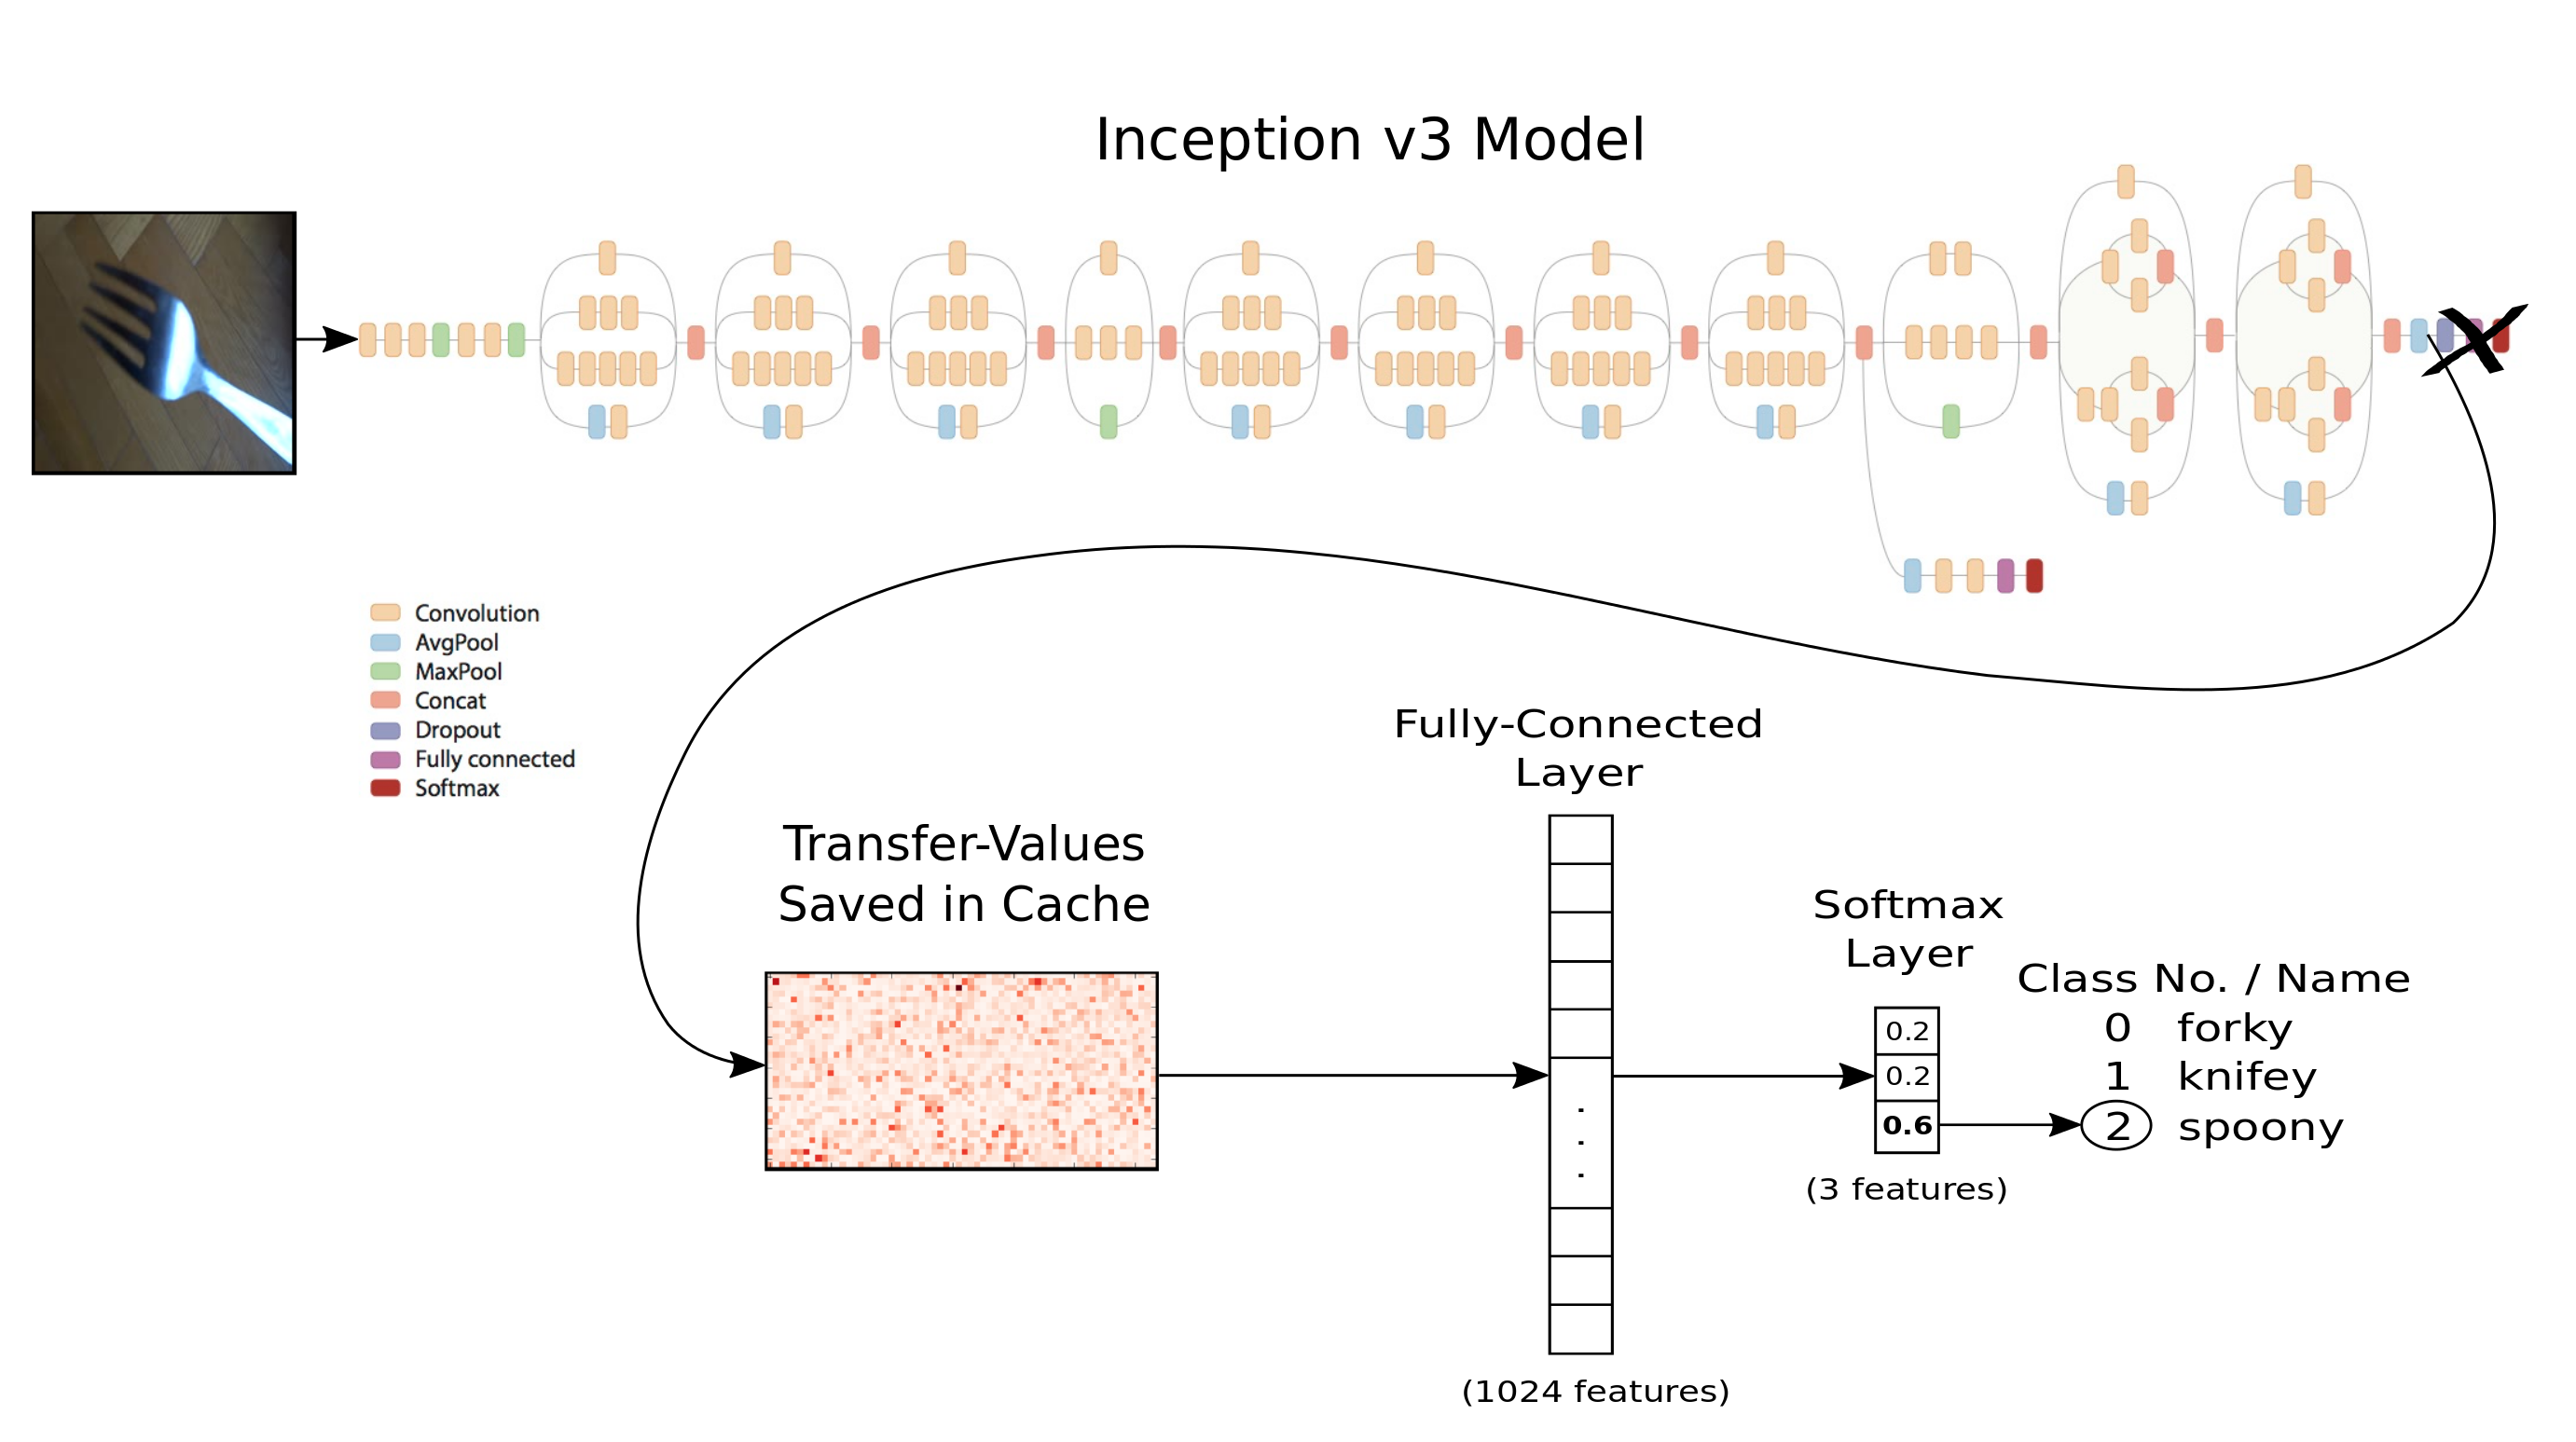

In [1]:
from IPython.display import Image, display
Image('images/09_transfer_learning_flowchart.png')

## 导入

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [2]:
tf.__version__

'1.6.0'

PrettyTensor 版本:

In [3]:
pt.__version__

'0.7.4'

## 载入数据

In [4]:
import knifey

`knifey`模块中已经定义好了数据维度，因此我们需要时只要导入就行。

In [6]:
from knifey import num_classes

设置电脑上保存数据集的路径。

In [7]:
# knifey.data_dir = "data/knifey-spoony/"

设置本教程中保存缓存文件的文件夹。

In [8]:
data_dir = knifey.data_dir

Knifey-Spoony数据集大概有22MB，如果给定路径没有找到文件的话，将会自动下载。

In [9]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


现在载入数据集。程序会遍历子文件夹来获取所有`*.jpg`格式的图像，然后将文件名放入训练集和测试集的两个列表中。实际上此时并未载入图像，在计算好transfer-values之后再执行载入。

文件名列表将会保存到硬盘上，我们必须确保它们按之后重载数据集的顺序排列。这个很重要，这样我们就能知道哪些图像对应哪些transfer-values。

In [10]:
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl


### 你的数据

你可以用自己的图像来代替knifey-spoony数据集。需要创建一个`dataset.py`模块中的`DataSet`对象。最好的方法是使用`load_cache()`封装函数，它会自动将图像列表保存到缓存文件中，因此你需要确保列表顺序和后面生成的transfer-values顺顺序一致。

每个类别的图像需要组织在各自的文件夹里。`dataset.py`模块中的文档有更多细节。

In [11]:
# This is the code you would run to load your own image-files.
# It has been commented out so it won't run now.

# from dataset import load_cached
# dataset = load_cached(cache_path='my_dataset_cache.pkl', in_dir='my_images/')
# num_classes = dataset.num_classes

### 训练集和测试集

获取类别名。

In [12]:
class_names = dataset.class_names
class_names

['forky', 'knifey', 'spoony']

获取测试集。它返回图像的文件路径、整形类别号和One-Hot编码的类别号数组，称为标签。

In [13]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

打印第一个图像地址，看看是否正确。

In [14]:
image_paths_train[0]

'/home/magnus/development/TensorFlow-Tutorials/data/knifey-spoony/forky/forky-05-0023.jpg'

获取测试集。

In [15]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

打印第一个图像地址，看看是否正确。

In [16]:
image_paths_test[0]

'/home/magnus/development/TensorFlow-Tutorials/data/knifey-spoony/forky/test/forky-test-01-0163.jpg'

现在已经载入了Knifey-Spoony数据集，它包含4700张图像以及相应的标签（图像的分类）。数据集被手动地分为两个子集，训练集和测试集。

In [17]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		4170
- Test-set:		530


### 用来绘制图像的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [18]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 载入图像的帮助函数

数据集并未载入实际图像，在训练集和测试集中各有一个图像（地址）列表。下面的帮助函数载入了一些图像文件。

In [19]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### 绘制一些图像看看数据是否正确

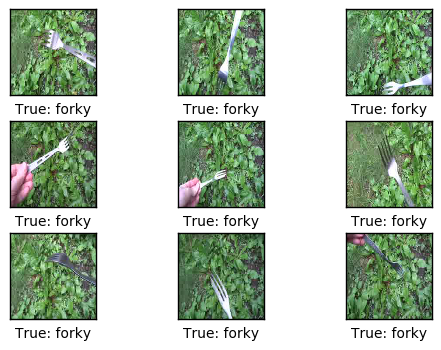

In [20]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## 下载Inception模型

从网上下载Inception模型。这是你保存数据文件的默认文件夹。如果文件夹不存在就自动创建。

In [21]:
# inception.data_dir = 'inception/'

如果文件夹中不存在Inception模型，就自动下载。 它有85MB。

更多详情见教程#07。

In [22]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## 载入Inception模型

载入模型，为图像分类做准备。

注意warning信息，以后可能会导致程序运行失败。

In [23]:
model = inception.Inception()

## 计算 Transfer-Values

导入用来从Inception模型中获取transfer-values的帮助函数。

In [24]:
from inception import transfer_values_cache

设置训练集和测试集缓存文件的目录。

In [25]:
file_path_cache_train = os.path.join(data_dir, 'inception-knifey-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-knifey-test.pkl')

In [26]:
print("Processing Inception transfer-values for training-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/knifey-spoony/inception-knifey-train.pkl


In [27]:
print("Processing Inception transfer-values for test-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/knifey-spoony/inception-knifey-test.pkl


检查transfer-values的数组大小。在训练集中有4170张图像，每张图像有2048个transfer-values。

In [28]:
transfer_values_train.shape

(4170, 2048)

同样，在测试集中有530张图像，每张图像有2048个transfer-values。

In [29]:
transfer_values_test.shape

(530, 2048)

### 绘制transfer-values的帮助函数

In [30]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


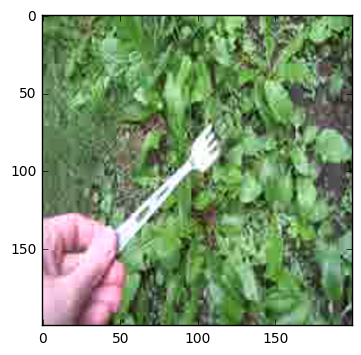

Transfer-values for the image using Inception model:


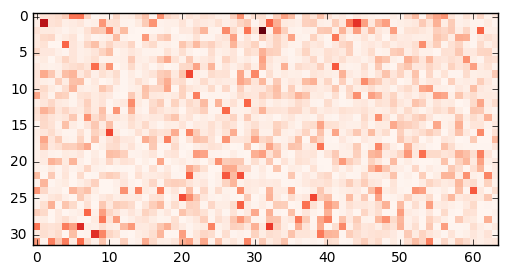

In [31]:
plot_transfer_values(i=100)

Input image:


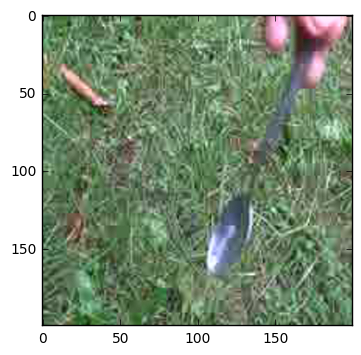

Transfer-values for the image using Inception model:


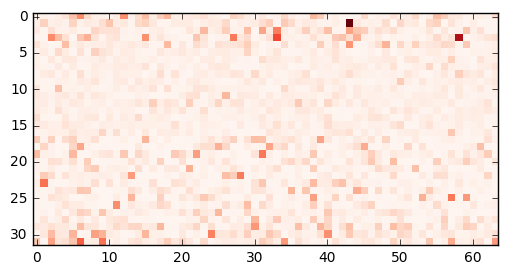

In [32]:
plot_transfer_values(i=300)

## transfer-values的PCA分析结果

用scikit-learn里的主成分分析(PCA),将transfer-values的数组维度从2048维降到2维，方便绘制。

In [33]:
from sklearn.decomposition import PCA

创建一个新的PCA-object，将目标数组维度设为2。

In [34]:
pca = PCA(n_components=2)

计算PCA需要一段时间。本文的数据集并不是很大，否则你需要挑选训练集中的一小部分，来加速计算。

In [35]:
# transfer_values = transfer_values_train[0:3000]
transfer_values = transfer_values_train

获取你选取的样本的类别号。

In [36]:
# cls = cls_train[0:3000]
cls = cls_train

保数组有4170份样本,每个样本有2048个transfer-values。

In [37]:
transfer_values.shape

(4170, 2048)

用PCA将transfer-value从2048维降低到2维。

In [38]:
transfer_values_reduced = pca.fit_transform(transfer_values)

数组现在有4170个样本，每个样本两个值。

In [39]:
transfer_values_reduced.shape

(4170, 2)

帮助函数用来绘制降维后的transfer-values。

In [40]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

画出用PCA降维后的transfer-values。用3种不同的颜色来表示Knifey-Spoony数据集中不同的类别。颜色有很多重叠部分。这可能是因为PCA无法正确地分离transfer-values。

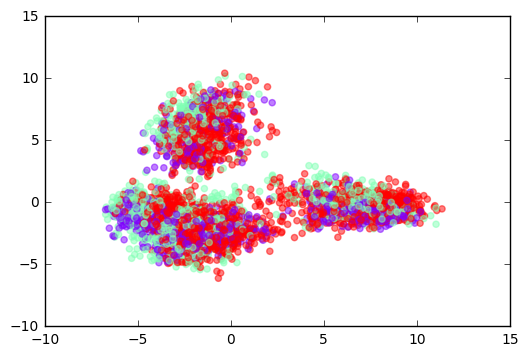

In [41]:
plot_scatter(transfer_values_reduced, cls=cls)

## transfer-values的t-SNE分析结果

In [42]:
from sklearn.manifold import TSNE

另一种降维的方法是t-SNE。不幸的是，t-SNE很慢，因此我们先用PCA将维度从2048减少到50。

In [43]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

创建一个新的t-SNE对象，用来做最后的降维工作，将目标维度设为2维。

In [44]:
tsne = TSNE(n_components=2)

用t-SNE执行最终的降维。目前在scikit-learn中实现的t-SNE可能无法处理很多样本的数据，所以如果你用整个训练集的话，程序可能会崩溃。

In [45]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

确保数组有4170份样本,每个样本有两个transfer-values。

In [46]:
transfer_values_reduced.shape

(4170, 2)

画出用t-SNE降低至二维的transfer-values，相比上面PCA的结果，它有更好的分离度。

这意味着由Inception模型得到的transfer-values似乎包含了足够多的信息，可以对Knifey-Sponny图像进行分类，然而还是有一些重叠部分，说明分离并不完美。

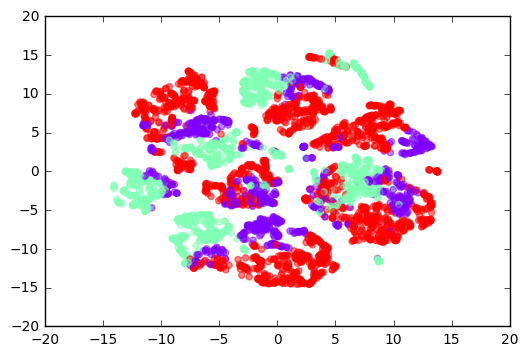

In [47]:
plot_scatter(transfer_values_reduced, cls=cls)

## TensorFlow中的新分类器

在我们将会在TensorFlow中创建一个新的神经网络。这个网络会把Inception模型中的transfer-values作为输入，然后输出Knifey-Spoony图像的预测类别。

这里假定你已经熟悉如何在TensorFlow中建立神经网络，否则请阅读教程#03。

### 占位符 （Placeholder）变量

首先需要找到transfer-values的数组长度，它是保存在Inception模型对象中的一个变量。

In [48]:
transfer_len = model.transfer_len

现在为输入的transfer-values创建一个placeholder变量，输入到我们新建的网络中。变量的形状是`[None, transfer_len]`，`None`表示它的输入数组包含任意数量的样本，每个样本元素个数为2048，即`transfer_len`。

In [49]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

为输入图像的真实类型标签定义另外一个placeholder变量。这是One-Hot编码的数组，包含10个元素，每个元素代表了数据集中的一种可能类别。

In [50]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

计算代表真实类别的整形数字。这也可能是一个placeholder变量。

In [51]:
y_true_cls = tf.argmax(y_true, dimension=1)

### 神经网络

创建在Knifey-Spoony数据集上做分类的神经网络。它将Inception模型得到的transfer-values作为输入，保存在placeholder变量`x`中。网络输出预测的类别`y_pred`。

教程#03中有更多使用Pretty Tensor构造神经网络的细节。

In [52]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### 优化方法

创建一个变量来记录当前优化迭代的次数。

In [53]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

优化新的神经网络的方法。

In [54]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### 分类准确率

网络的输出`y_pred`是一个包含3个元素的数组。类别号是数组中最大元素的索引。

In [55]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

创建一个布尔向量，表示每张图像的真实类别是否与预测类别相同。

In [56]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [57]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [58]:
session = tf.Session()

### 初始化变量

我们需要在开始优化weights和biases变量之前对它们进行初始化。

In [59]:
session.run(tf.global_variables_initializer())

### 获取随机训练batch的帮助函数

训练集中有4170张图像（以及保存transfer-values的数组）。用这些图像（transfer-vlues）计算模型的梯度会花很多时间。因此，我们在优化器的每次迭代里只用到了一小部分的图像（transfer-vlues）。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [60]:
train_batch_size = 64

函数用来从训练集中选择随机batch的transfer-vlues。

In [61]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### 执行优化迭代的帮助函数

函数用来执行一定数量的优化迭代，以此来逐渐改善网络层的变量。在每次迭代中，会从训练集中选择新的一批数据，然后TensorFlow在这些训练样本上执行优化。每100次迭代会打印出进度。

In [62]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## 展示结果的帮助函数

### 绘制错误样本的帮助函数

函数用来绘制测试集中被误分类的样本。

In [63]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

### 绘制混淆（confusion）矩阵的帮助函数

In [64]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### 计算分类的帮助函数

这个函数用来计算图像的预测类别，同时返回一个代表每张图像分类是否正确的布尔数组。  

由于计算可能会耗费太多内存，就分批处理。如果你的电脑死机了，试着降低batch-size。

In [65]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

计算测试集上的预测类别。

In [66]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### 计算分类准确率的帮助函数

这个函数计算了给定布尔数组的分类准确率，布尔数组表示每张图像是否被正确分类。比如， `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`。

In [67]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### 展示分类准确率的帮助函数

函数用来打印测试集上的分类准确率。

为测试集上的所有图片计算分类会花费一段时间，因此我们直接从这个函数里调用上面的函数，这样就不用每个函数都重新计算分类。

In [68]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 结果

## 优化之前的性能

测试集上的准确度很低，这是由于模型只做了初始化，并没做任何优化，所以它只是对图像做随机分类。

In [69]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 30.0% (159 / 530)
Confusion Matrix:
[151   0   0] (0) forky
[122   3  12] (1) knifey
[237   0   5] (2) spoony
 (0) (1) (2)


## 1000次优化迭代后的性能

在1000次优化迭代之后，测试集上的准确率大约为70%。

In [70]:
optimize(num_iterations=1000)

Global Step:    100, Training Batch Accuracy:  95.3%
Global Step:    200, Training Batch Accuracy:  96.9%
Global Step:    300, Training Batch Accuracy:  98.4%
Global Step:    400, Training Batch Accuracy: 100.0%
Global Step:    500, Training Batch Accuracy: 100.0%
Global Step:    600, Training Batch Accuracy: 100.0%
Global Step:    700, Training Batch Accuracy: 100.0%
Global Step:    800, Training Batch Accuracy: 100.0%
Global Step:    900, Training Batch Accuracy: 100.0%
Global Step:   1000, Training Batch Accuracy: 100.0%
Time usage: 0:00:02


Accuracy on Test-Set: 71.3% (378 / 530)
Example errors:


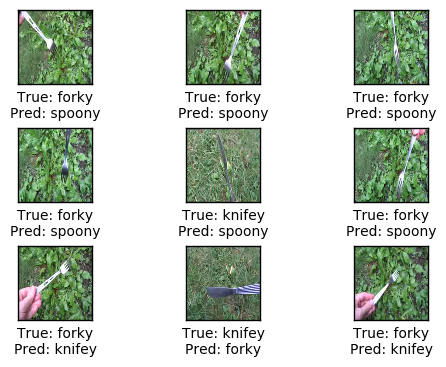

Confusion Matrix:
[35 36 80] (0) forky
[  6 101  30] (1) knifey
[  0   0 242] (2) spoony
 (0) (1) (2)


In [71]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## 关闭TensorFlow会话

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。注意，我们需要关闭两个TensorFlow-session，每个模型对象各有一个。

In [72]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()
# session.close()

## 总结

这篇教程向我们展示了如何在Inception模型上用自己的图像做迁移学习。教程中使用的几千张图像是我们用一个Python[脚本](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py)从几分钟的录像视频中生成的。

然而，Knifey-Spoony数据集上的分类准确率不是很高，特别是叉子的图像。可能是因为Inception模型在ImageNet数据集上训练，而其中只有16张叉子的图像，但它却包括了1200多张勺子图像和1300多张餐刀图像。因此Inception模型很可能无法正确识别叉子。

因此我们需要另一种技巧来微调Inception模型，这样它就能更好地识别叉子。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 试着为新的分类器改变神经网络。如果你删掉全连接层或添加更多的全连接层会发生什么？
* 如果你执行更多或更少的迭代会出现什么情况？
* 试着在训练集中删掉一些勺子的图像，这样每种类别的图象数量就差不多（先做个备份）。你还需要删除所有文件名带有`*.pkl`的缓存文件，然后重新运行Notebook。这样会提高分类准确率吗？比较改变前后的混淆矩阵。
* 用`convert.py` 脚本建立你自己的数据集。比如，录下汽车和摩托车的视频，然后创建一个分类系统。
* 需要从你创建的训练集中删除一些不明确的图像吗？如何你删掉这些图像之后，分类准确率有什么变化？
* 改变Notebook，这样你可以输入单张图像而不是整个数据集。你不用从Inception模型中保存transfer-values。
* 你能创建一个比用Inception模型来做迁移学习更好的或更快的神经网络吗？
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.